# **Projekat iz predmeta Mašinsko učenje**

**Studentica:** Iman Mahmutović

**Broj indexa:** 5848/M

**Tema:** Predikcija srčanog udara (Tema 1)

# **Eksploracija podataka**

Učitavanje podataka:

In [ ]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/data.csv'
data = pd.read_csv(file_path)



Mounted at /content/drive


Miješanje podataka i razdvajanje atributa od oznaka:




In [ ]:
data = data.sample(n=len(data))
data = data.reset_index(drop=True)

y = data["stroke"]
X = data.drop(columns = ["stroke"])

Atribut *smoking_status* sadrži *Unknown* vrijednosti pa te vrijednosti mijenjamo najučestalijom. Također atribut *bmi* sadrži NaN vrijednosti pa njih mijenjamo srednjom vrijednošću svih vrijednosti tog atributa.

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

column_trans = ColumnTransformer(
     [('imp_frequency', SimpleImputer(missing_values="Unknown", strategy='most_frequent'), ['smoking_status']),
     ('imp_mean', SimpleImputer(missing_values=np.nan, strategy='mean'), ['bmi'])],
      remainder='passthrough'
)

X = column_trans.fit_transform(X)
column_names = ['smoking_status', 'bmi', 'id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level']
X = pd.DataFrame(X, columns = column_names)

null_counts = X.isna().sum().sum()
print(f"Ukupan broj null vrijednosti: {null_counts}")



Ukupan broj null vrijednosti: 0


Sve kategoričke varijable enkodiramo obzirom da modeli rade sa numeričkim vrijednostima. Kategoričke varijable mijenjamo brojevima 0,1,2.. u zavisnosti koliko ih ima.

In [ ]:
le = LabelEncoder()
label_gender = le.fit_transform(data['gender'])
label_married = le.fit_transform(data['ever_married'])
label_work = le.fit_transform(data['work_type'])
label_residence = le.fit_transform(data['Residence_type'])
label_smoking = le.fit_transform(data['smoking_status'])

X.drop(['gender','ever_married', 'work_type', 'Residence_type', 'smoking_status'], axis=1, inplace=True)
X['gender'] = label_gender
X['ever_married'] = label_married
X['work_type'] = label_work
X['Residence_type'] = label_residence
X['smoking_status'] = label_smoking


Dijelimo skup podataka na tri podskupa: za učenje, validaciju i testiranje. Također ovdje skaliramo podatke, preciznije vršimo standardizaciju. Ovim postižemo da je srednja vrijednost svih podataka 0 a varijansa 1.

In [ ]:
from sklearn.preprocessing import StandardScaler

# podjela trening dataseta na 80% za treniranje, 10% za validaciju tokom treniranja i 10% za testni set
num_training = 3848
num_validation = 481
num_test = 481

# veličina inputa
D = 11

X_val = X.iloc[num_test + num_training : num_test + num_training + num_validation]
y_val = y.iloc[num_test + num_training : num_test + num_training + num_validation]
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

X_train = X.iloc[num_test : num_test + num_training]
y_train = y.iloc[num_test : num_test + num_training]
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_test = X.iloc[:num_test]
y_test = y.iloc[:num_test]

# standardizacija podataka (oduzimamo srednju vrijednost i dijelimo sa standardnom devijacijom)

mean = np.mean(X_train, axis=0)
X_train -= mean
X_val -= mean
X_test -= mean

std = np.std(X_train, axis=0)
X_train /= std
X_val /= std
X_test /= std

data = {
    'X_train': X_train,
    'y_train': y_train,
    'X_val': X_val,
    'y_val': y_val
}

print('Oblik podataka za treniranje: ', X_train.shape)
print('Oblik oznaka podataka za treniranje: ', y_train.shape)
print('Oblik podataka za validaciju: ', X_val.shape)
print('Oblik oznaka podataka za validaciju: ', y_val.shape)
print('Oblik podataka za testiranje: ', X_test.shape)
print('Oblik oznaka podataka za testiranje: ', y_test.shape)

Oblik podataka za treniranje:  (3848, 11)
Oblik oznaka podataka za treniranje:  (3848,)
Oblik podataka za validaciju:  (481, 11)
Oblik oznaka podataka za validaciju:  (481,)
Oblik podataka za testiranje:  (481, 11)
Oblik oznaka podataka za testiranje:  (481,)


Provjera korelacije između atributa:

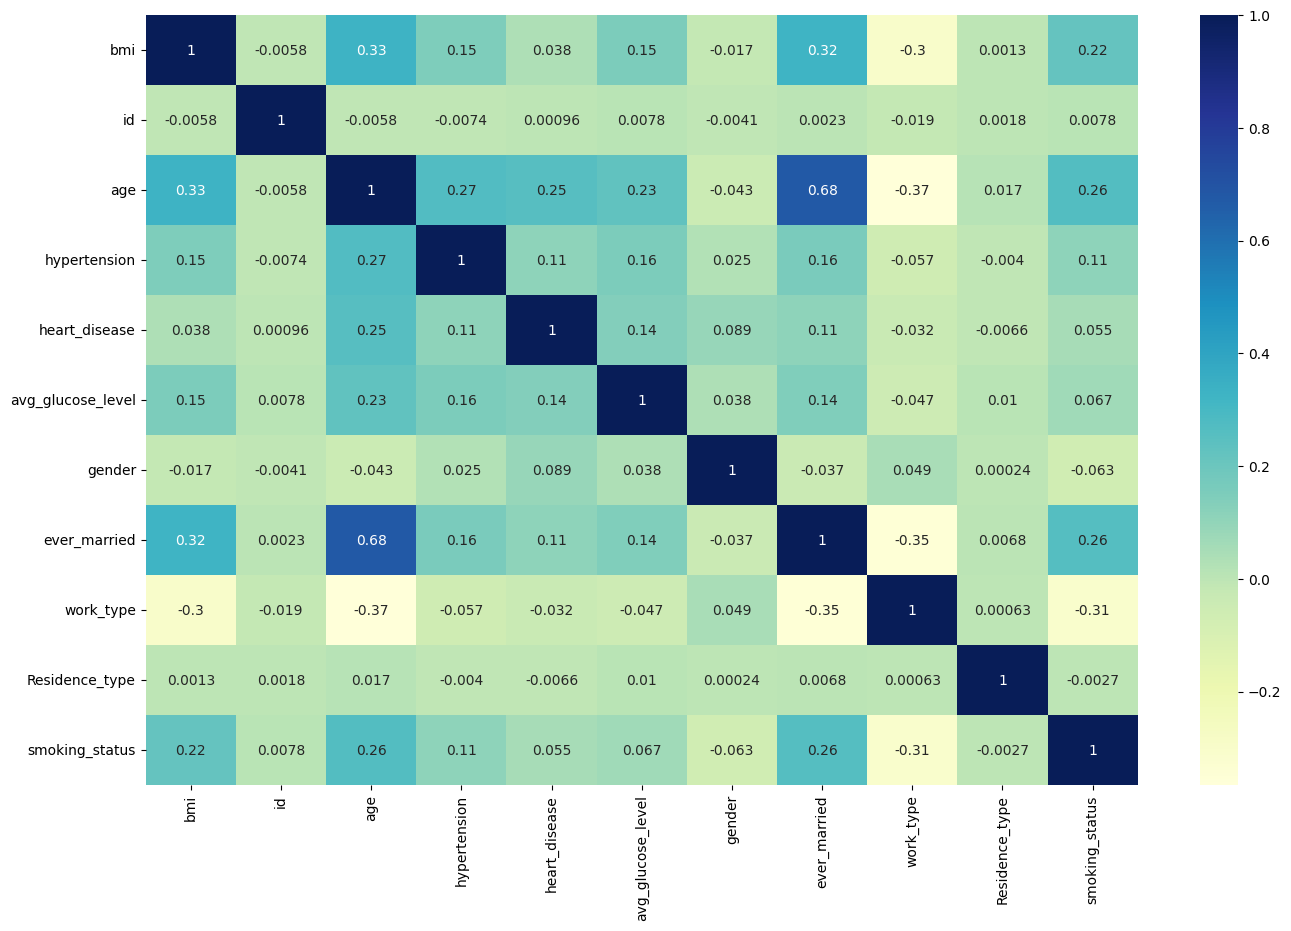

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (16, 10))
sns.heatmap(X_train.corr(), annot = True, cmap="YlGnBu")
plt.show()

Vidimo da atributi *age* i *ever_married* imaju najveću korelaciju. Kasnije kada budemo trenirali model, uporedit ćemo rezultate kada izbacimo atribut *ever_married* i inače.

# **Treniranje modela**

### **Linearna regresija sa Ridge regularizacijom (L2 regularizacija)**

In [ ]:
from sklearn.linear_model import RidgeClassifier
clf_ridge = RidgeClassifier(max_iter = 1000)
clf_ridge.fit(X_train, y_train)


RidgeClassifier(max_iter=1000)

In [ ]:
from scipy import stats
from sklearn.metrics import mean_absolute_error
y_train_pred = clf_ridge.predict(X_train);
y_val_pred = clf_ridge.predict(X_val);
print("Greška na skupu za učenje: ",  mean_absolute_error(y_train, y_train_pred))
print("Greška na skupu za validaciju: ",  mean_absolute_error(y_val, y_val_pred))


Greška na skupu za učenje:  0.04885654885654886
Greška na skupu za validaciju:  0.04573804573804574


In [ ]:
from sklearn import metrics
def print_metrics(y_test, y_test_pred, averaging="binary"):
    print("Accuracy:",metrics.accuracy_score(y_test, y_test_pred),' - Classification Rate')
    print("Precision:",metrics.precision_score(y_test, y_test_pred, average=averaging),' - Precision - What proportion of positive identifications was actually correct? ')
    print("Recall:",metrics.recall_score(y_test, y_test_pred, average=averaging),' - Recall - What proportion of actual positives was identified correctly?')
    print("F1 Score:",metrics.f1_score(y_test, y_test_pred, average=averaging))


In [ ]:
print_metrics(y_val, y_val_pred)

Accuracy: 0.9542619542619543  - Classification Rate
Precision: 0.0  - Precision - What proportion of positive identifications was actually correct? 
Recall: 0.0  - Recall - What proportion of actual positives was identified correctly?
F1 Score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


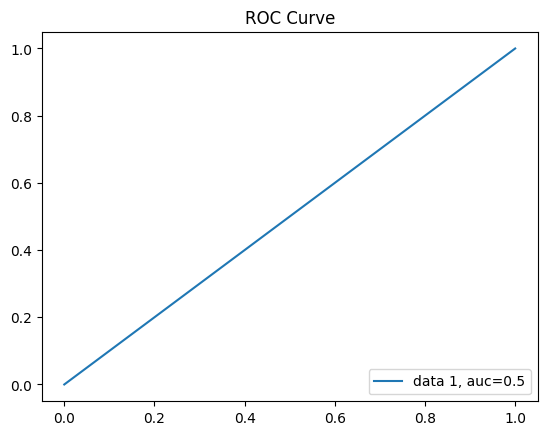

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_val, y_val_pred)
auc = metrics.roc_auc_score(y_val, y_val_pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title('ROC Curve')
plt.show()

Vidimo da naš model daje veoma dobar accuracy: čak 95% i da su empirijska i generalizacijska greška veoma bliske. Metrika koja nagovještava da nešto nije uredu je ROC Curve. Vidimo da je AUC tačno 0.5, što je najgora moguća situacija jer to znači da model nema sposobnost diskriminacije odnosno uopšte ne razlikuje klase. Razlog ovome je nebalansiranost klasa. Naime, model će za svaku instancu predvidjeti klasu 0 jer je to većinska klasa. Klasa 1 čini svega 4% skupa podataka za treniranje, što vidimo na chart-u ispod:

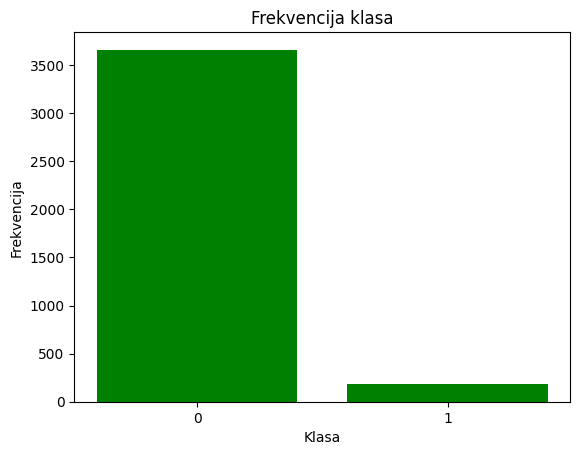

In [ ]:
class_counts = y_train.value_counts()
class_counts = class_counts.sort_values(ascending=False)
plt.bar(class_counts.index, class_counts.values, color='green')
plt.xlabel("Klasa")
plt.ylabel("Frekvencija")
plt.title("Frekvencija klasa")
plt.xticks([0.0, 1.0])
plt.show()

Da bi riješili ovaj problem, potrebno je uraditi resampling. Tačnije imamo dvije mogućnosti: možemo generisati vještačke primjere za klasu koja je u manjini ili obrisati instance većinske klase dok ne dobijemo ujednačen broj instanci za obje klase. I jedna i druga varijanta ima svoje prednosti i mane, npr., kada radimo upsampling možemo dobiti nekvalitetne sintetičke podatke dok kod downsampling-a možemo izgubiti neke bitne informacije. Obzirom da ćemo downsampling-om drastično smanjiti skup podataka što nas dovodi u opasnost overfitting-a, u nastavku ćemo uraditi upsampling.

In [ ]:
from sklearn.utils import resample
data_train = pd.concat([X_train, y_train], axis=1)

data_train_1 = data_train[data_train['stroke'] == 1]
data_train_0 = data_train[data_train['stroke'] == 0]

np.random.seed(42)

data_train_1 = resample(data_train_1,random_state=42,n_samples=3472,replace=True)
data_train = pd.concat([data_train_1,data_train_0])

y_train = data_train["stroke"]
X_train = data_train.drop(columns = ["stroke"])


Sada ćemo istrenirati model na novim podacima.

In [ ]:
clf_ridge = RidgeClassifier(max_iter = 1000)
clf_ridge.fit(X_train, y_train)
y_train_pred = clf_ridge.predict(X_train);
y_val_pred = clf_ridge.predict(X_val);

In [ ]:
print("Greška na skupu za učenje: ",  mean_absolute_error(y_train, y_train_pred))
print("Uspjeh na skupu za učenje: ", clf_ridge.score(X_train, y_train))
print("Greška na skupu za validaciju: ",  mean_absolute_error(y_val, y_val_pred))
print("Uspjeh na skupu za validaciju: ", clf_ridge.score(X_val, y_val))
print_metrics(y_val, y_val_pred)


Greška na skupu za učenje:  0.2131239484015704
Uspjeh na skupu za učenje:  0.7868760515984297
Greška na skupu za validaciju:  0.28482328482328484
Uspjeh na skupu za validaciju:  0.7151767151767152
Accuracy: 0.7151767151767152  - Classification Rate
Precision: 0.11920529801324503  - Precision - What proportion of positive identifications was actually correct? 
Recall: 0.8181818181818182  - Recall - What proportion of actual positives was identified correctly?
F1 Score: 0.20809248554913296


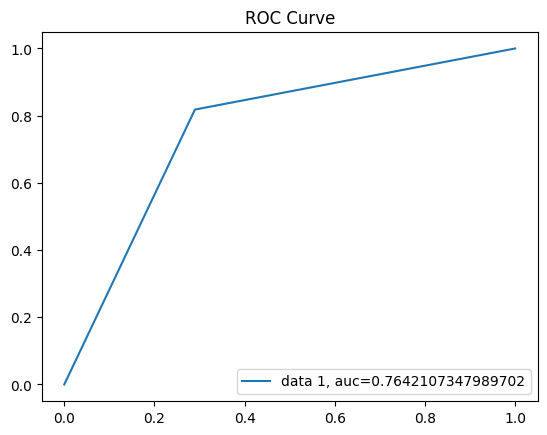

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_val, y_val_pred)
auc = metrics.roc_auc_score(y_val, y_val_pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title('ROC Curve')
plt.show()

Vidimo da su sada veće greške nego prošli put i da je accuracy manji. Međutim uvjerili smo se da accuracy nije vjerodostojna metrika pri procjeni modela. Bitna stvar je da je sada AUC približno 0.8 što iako nije idealno, mnogo je bolje od prošlog puta.

Sada ćemo izbaciti atribut *ever_married* obzirom da je on u prilično visokoj korelaciji sa atributom *age*. Mogli bi izbaciti i atribut *age* ali taj atribut je bitniji u predikciji srčanog udara nego *ever_married*.

In [ ]:
X_train_modified = X_train.drop(columns = ["ever_married"])
X_val_modified = X_val.drop(columns = ["ever_married"])
clf_ridge_2 = RidgeClassifier(max_iter = 1000)
clf_ridge_2.fit(X_train_modified, y_train)
y_train_pred_modified = clf_ridge_2.predict(X_train_modified);
y_val_pred_modified = clf_ridge_2.predict(X_val_modified);

In [ ]:
print("Greška na skupu za učenje: ",  mean_absolute_error(y_train, y_train_pred_modified))
print("Uspjeh na skupu za učenje: ", clf_ridge_2.score(X_train_modified, y_train))
print("Greška na skupu za validaciju: ",  mean_absolute_error(y_val, y_val_pred_modified))
print("Uspjeh na skupu za validaciju: ", clf_ridge_2.score(X_val_modified, y_val))
print_metrics(y_val, y_val_pred_modified)

Greška na skupu za učenje:  0.21887268648345484
Uspjeh na skupu za učenje:  0.7811273135165452
Greška na skupu za validaciju:  0.2910602910602911
Uspjeh na skupu za validaciju:  0.7089397089397089
Accuracy: 0.7089397089397089  - Classification Rate
Precision: 0.11688311688311688  - Precision - What proportion of positive identifications was actually correct? 
Recall: 0.8181818181818182  - Recall - What proportion of actual positives was identified correctly?
F1 Score: 0.20454545454545453


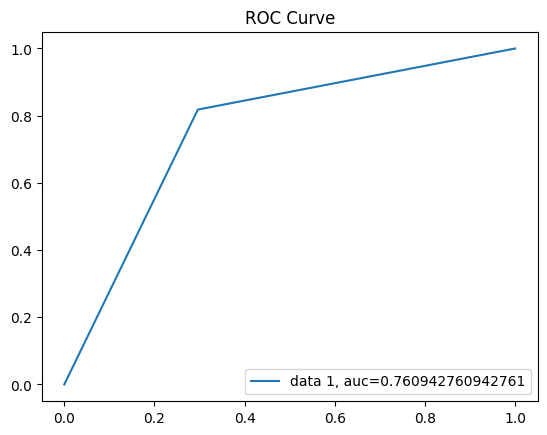

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_val, y_val_pred_modified)
auc = metrics.roc_auc_score(y_val, y_val_pred_modified)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title('ROC Curve')
plt.show()

Vidimo da smo dobili slične rezultate bez atributa *ever_married* dakle zaključujemo da se ne isplati izbaciti ovaj atribut.

### **Metoda potpornih vektora**

In [ ]:
from sklearn import svm
clf_svm = svm.SVC(kernel='linear', C = 1)
clf_svm.fit(X_train, y_train)
y_val_pred_svm = clf_svm.predict(X_val)

In [ ]:
print("Uspjeh na skupu za učenje: ", clf_svm.score(X_train, y_train))
print("Uspjeh na skupu za validaciju: ", clf_svm.score(X_val, y_val))
print_metrics(y_val, y_val_pred_svm)

Uspjeh na skupu za učenje:  0.7895401009534493
Uspjeh na skupu za validaciju:  0.7172557172557172
Accuracy: 0.7172557172557172  - Classification Rate
Precision: 0.11486486486486487  - Precision - What proportion of positive identifications was actually correct? 
Recall: 0.7727272727272727  - Recall - What proportion of actual positives was identified correctly?
F1 Score: 0.2


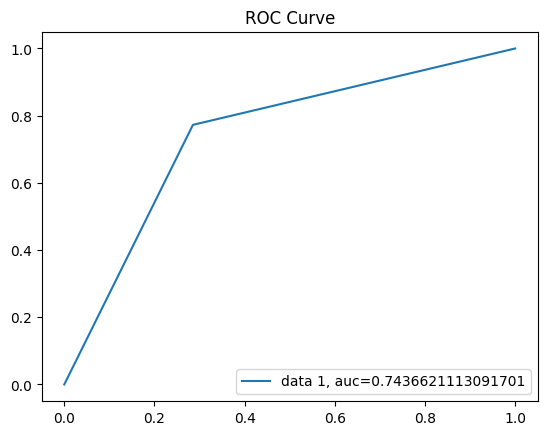

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_val, y_val_pred_svm)
auc = metrics.roc_auc_score(y_val, y_val_pred_svm)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title('ROC Curve')
plt.show()

### **Logistička regresija**

In [ ]:
from sklearn.linear_model import LogisticRegression
clf_log = LogisticRegression()
clf_log.fit(X_train, y_train)
y_val_pred_log = clf_log.predict(X_val)

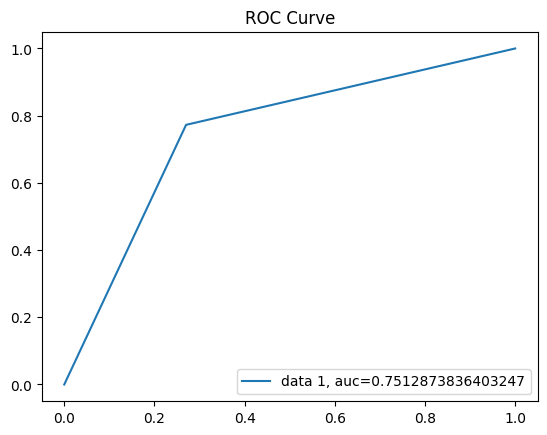

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_val, y_val_pred_log)
auc = metrics.roc_auc_score(y_val, y_val_pred_log)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title('ROC Curve')
plt.show()

# **Evaluacija modela**

Ovdje ćemo testirati modele na skupu podataka za testiranje i uporediti njihove performanse.

In [ ]:
y_test_pred_ridge = clf_ridge.predict(X_test)

In [ ]:
y_test_pred_svm = clf_svm.predict(X_test)

<ipython-input-27-a6fb14dde667>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - y_test_pred_ridge), bins = 20)


Text(0.5, 0, 'Greška')

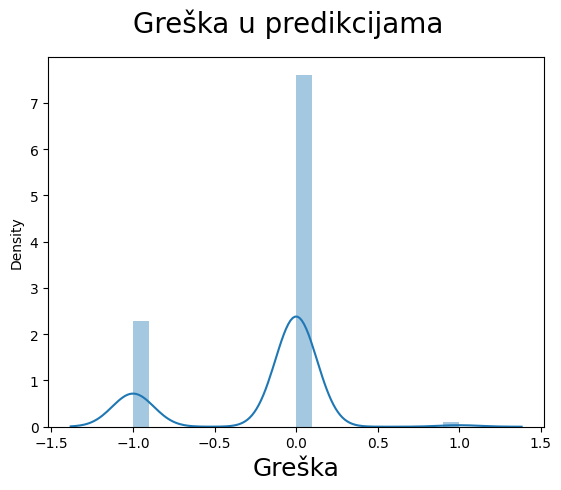

In [ ]:
fig = plt.figure()
sns.distplot((y_test - y_test_pred_ridge), bins = 20)
fig.suptitle('Greška u predikcijama', fontsize = 20)
plt.xlabel('Greška', fontsize = 18)

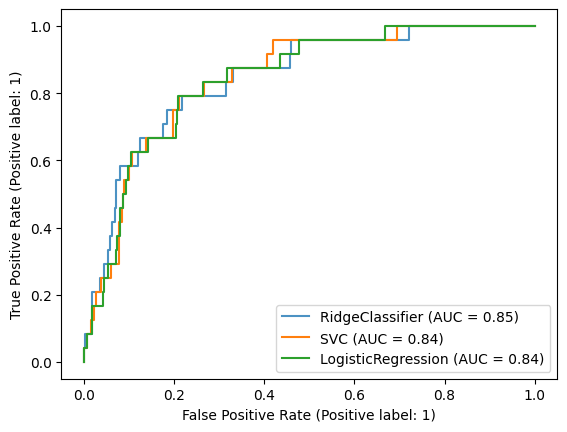

In [ ]:
from sklearn.metrics import RocCurveDisplay
ax = plt.gca()
ridge_disp = RocCurveDisplay.from_estimator(clf_ridge, X_test, y_test, ax=ax, alpha=0.8)
svc_disp = RocCurveDisplay.from_estimator(clf_svm, X_test, y_test, ax = ax)
log_disp = RocCurveDisplay.from_estimator(clf_log, X_test, y_test, ax = ax)
plt.show()

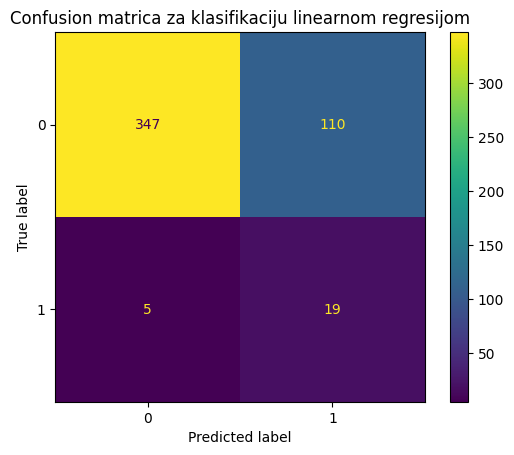

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_test_pred_ridge, labels=clf_ridge.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf_ridge.classes_)
disp.plot()
plt.title('Confusion matrica za klasifikaciju linearnom regresijom')
plt.show()

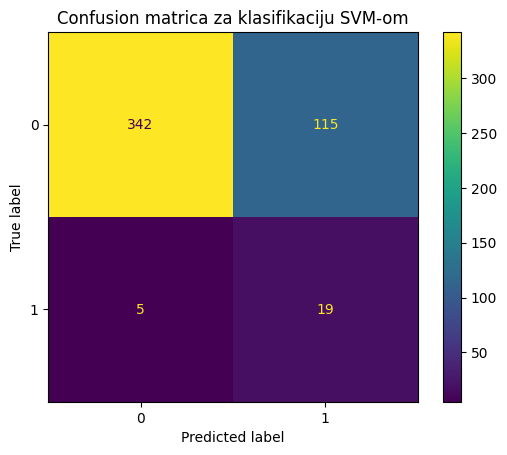

In [ ]:
cm = confusion_matrix(y_test, y_test_pred_svm, labels=clf_svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf_svm.classes_)
disp.plot()
plt.title('Confusion matrica za klasifikaciju SVM-om')
plt.show()

Vidimo da su performanse ova tri modela skoro pa identične. Kod modela SVM-a bi još mogli podešavati parametar C, tačnije povećati ga i pratiti sposobnost generalizacije tako treniranog modela međutim time ćemo i povećati složenost  pa će treniranje biti sporije. To što su performanse ova linearne regresije i SVM-a veoma slična zapravo i ima smisla obzirom da je ciljna funkcija optimizacijskog problema SVM-a identična L2 regulariziranoj empirijskoj grešci kod linearne regresije.